In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
ds = pd.read_csv('//content//retail.csv' , encoding = 'unicode_escape')
ds.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
print(ds.info())
print(ds.shape)
print(ds.isnull().sum())
ds = ds.dropna()
print(ds.info())
print(ds.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284431 entries, 0 to 284430
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    284431 non-null  object 
 1   StockCode    284431 non-null  object 
 2   Description  283352 non-null  object 
 3   Quantity     284431 non-null  int64  
 4   InvoiceDate  284431 non-null  object 
 5   UnitPrice    284431 non-null  float64
 6   CustomerID   203410 non-null  float64
 7   Country      284431 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 17.4+ MB
None
(284431, 8)
InvoiceNo          0
StockCode          0
Description     1079
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     81021
Country            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 203410 entries, 0 to 284430
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0 

In [6]:
#data preprocessing 
ds['CustomerID'] = ds['CustomerID'].astype(str)
ds['Amount'] = ds['Quantity']*ds['UnitPrice']
rfm_ds_m = ds.groupby('CustomerID')['Amount'].sum()
rfm_ds_m.reset_index()
rfm_ds_m.columns = ['CustomerID', 'Amount']
print(rfm_ds_m)

CustomerID
12346.0       0.00
12347.0    2205.95
12348.0    1487.24
12350.0     334.40
12352.0     601.18
            ...   
18277.0     -12.75
18280.0     180.60
18281.0      80.82
18283.0     985.77
18287.0     765.28
Name: Amount, Length: 3189, dtype: float64


In [7]:
rfm_ds_f = ds.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID', 'Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        102
2       12348.0         28
3       12350.0         17
4       12352.0         48
...         ...        ...
3184    18277.0          1
3185    18280.0         10
3186    18281.0          7
3187    18283.0        400
3188    18287.0         29

[3189 rows x 2 columns]


In [8]:
ds['InvoiceDate'] = pd.to_datetime(ds['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(ds['InvoiceDate'])
ds['Diff'] = max_date - ds['InvoiceDate']
rfm_ds_p = ds.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID','Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   194
1       12347.0    51
2       12348.0   117
3       12350.0   178
4       12352.0   130
...         ...   ...
3184    18277.0   186
3185    18280.0   146
3186    18281.0    49
3187    18283.0    16
3188    18287.0    70

[3189 rows x 2 columns]


In [9]:
rfm_ds_final = pd.merge(rfm_ds_m,rfm_ds_f,on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final,rfm_ds_p,on='CustomerID',how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      194
1    12347.0  2205.95        102       51
2    12348.0  1487.24         28      117
3    12350.0   334.40         17      178
4    12352.0   601.18         48      130


In [10]:
#OUTLIERS

Q1 = rfm_ds_final.Amount.quantile(0.05)
Q3 = rfm_ds_final.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount >= Q1 - 1.5*IQR) & (rfm_ds_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.05)
Q3 = rfm_ds_final.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency >= Q1 - 1.5*IQR) & (rfm_ds_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.05)
Q3 = rfm_ds_final.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency >= Q1 - 1.5*IQR) & (rfm_ds_final.Frequency <= Q3 + 1.5*IQR)]

In [11]:
print(rfm_ds_final.shape)

(3140, 4)


In [12]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.303034,0.002092,0.801653
1,0.458942,0.211297,0.210744
2,0.408147,0.056485,0.483471
3,0.326668,0.033473,0.735537
4,0.345523,0.098326,0.537190


In [13]:
#model creation
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[0 2 0 ... 2 1 2]


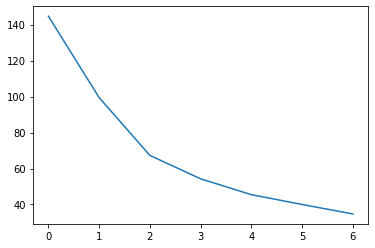

In [14]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

In [15]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5296661278959527
For n_clusters=3, the silhouette score is 0.49750700181465174
For n_clusters=4, the silhouette score is 0.45454018525155265
For n_clusters=5, the silhouette score is 0.396152521907954
For n_clusters=6, the silhouette score is 0.4022214882018481
For n_clusters=7, the silhouette score is 0.38701114698253575
For n_clusters=8, the silhouette score is 0.396015444026467


In [16]:
# kmeans = KMeans(n_clusters=3, max_iter=50)
# kmeans.fit(rfm_ds_scaled)
# print(kmeans.labels_)
rfm_ds_final['Cluster_Id'] = lbs
rfm_ds_final.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,194,0
1,12347.0,2205.95,102,51,2
2,12348.0,1487.24,28,117,0
3,12350.0,334.40,17,178,0
4,12352.0,601.18,48,130,0


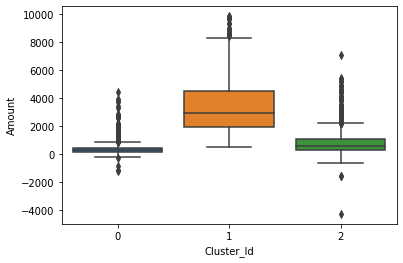

In [17]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_ds_final)

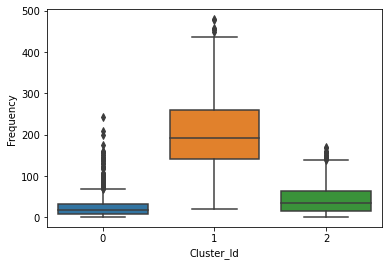

In [18]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_ds_final)

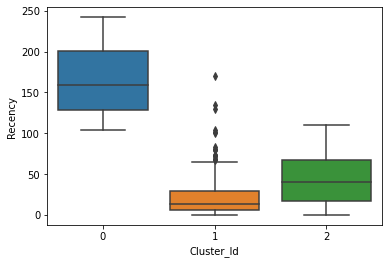

In [19]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_ds_final)